In [1]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import sklearn

dataset = pd.read_csv('data2/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
# dataset.raw_fft.iloc[0]

Populating the interactive namespace from numpy and matplotlib


# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [2]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

# no right subj, wrong task

In [3]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, positive.shape    # 40 per subject, 512 readings

((40, 516), (40, 516))

In [4]:
dataset['label'].unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x', 'breatheclosed', 'word_c',
       'phrase_c', 'face_c', 'song_c', 'sport_c'], dtype=object)

In [5]:
dataset.head()

,time,subject,session,label,raw_fft
0,2017-07-22T20:37:13.267775811Z,A,0,unlabeled,"[10.3113040924, 14.77069664, 12.213514328, 9.7..."
1,2017-07-22T20:37:14.253040444Z,A,0,unlabeled,"[11.2151269913, 14.9568557739, 10.8369417191, ..."
2,2017-07-22T20:37:15.372317746Z,A,0,unlabeled,"[6.34600162506, 12.5924711227, 10.8416910172, ..."
3,2017-07-22T20:37:16.483798739Z,A,0,unlabeled,"[10.0782966614, 16.9934558868, 18.5345039368, ..."
4,2017-07-22T20:37:17.471855277Z,A,0,unlabeled,"[4.42960739136, 9.05199050903, 4.41912555695, ..."


## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

### Response

I think that this simple configuration would be the most useful: Positive - Some person *p* thinking the right task; Negative - same *p* thinking the wrong task. Data like John's 58-day dataset is a good first step, but didn't seem to be meant exactly for evaluating passthoughts. I would like to try a similar longitudinal experiment out on myself, but only include about four brief tasks: relaxing, thinking a wrong password, feeling agitated/worried, and thinking the right password. I tried to test this out with John's "think of a company" task, but would ideally evaluate with data more suited to passthoughts.

The two qualities of a password are restricted access to one or a group of people, and that the password does not change unintentionally. Suppose we identify that the right person is trying to enter their password but inputs the wrong thing. This may signify that they forgot their password, but more seriously may mean that the person is in a state (drunk, being coerced) unfit for accessing whatever they're trying to access. So if we could identify that the person was thinking the wrong task, then this could be very useful information itself.

A side benefit from classifying this way is by using only one person, since it's likely that there would be less overfitting. However, lots more data would have to be collected since our sample size is only one person, and we would still have to fulfill the other requirement of a password (identifying whether the person was the right person or not in the first place).

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [6]:
X = np.concatenate([positive, negative])

In [7]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [8]:
# Your code here....

def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [9]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [10]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so users don't get frustrated constantly re-trying their passthought).

In [11]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(list(filter(lambda x: x==0, y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x==1, y_pred)))
    return far, frr

In [12]:
far, frr = far_frr(clf, X_validate, y_validate)
f'FAR: {far*100}% - FRR: {frr*100}%'

'FAR: 30.0% - FRR: 0.9779951100244498%'

Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [13]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]   # 0 = accept

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [14]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
f'FAR: {far*100}% - FRR: {frr*100}%'

'FAR: 0.0% - FRR: 100.0%'

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

### What is changing? How do we know?

Read in all of John's csv files and make dictionaries for values for each day.

In [90]:
days = {}
days_vid = {}
vid_vals = {}
time_vals = {}

for i in range(59):
    if i == 36:
        continue
    days[i] = pd.read_csv('longitudinal-packaged/labeled/' + str(i) + '.csv')    
    days[i] = days[i].rename(columns={'Unnamed: 0':'num', 'Time':'time', ' Value':'value', 'event name':'event'})
    days_vid[i] = days[i][days[i].event == 'video-ver2']
    vid_vals[i] = days_vid[i].value.values
    time_vals[i] = days_vid[i].time.values    

There are 58 arrays in vid_vals (0-58, no i = 36), each vid_vals[i] representing data during the video task from one day. Each has 30 full chunks of 512 samples.


In [248]:
days[0].event.unique()

array(['blinkInstruction', 'blink1', 'blink2', 'blink3', 'blink4',
       'blink5', 'relaxInstruction', 'relax', 'mathInstruction', 'math1',
       'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8',
       'math9', 'math10', 'math11', 'math12', 'musicInstruction', 'music',
       'videoInstruction', 'video-ver2', 'thinkOfItemsInstruction-ver2',
       'thinkOfItems-ver2', 'colorInstruction1', 'colorInstruction2',
       'readyRound1', 'colorRound1-1', 'colorRound1-2', 'colorRound1-3',
       'colorRound1-4', 'colorRound1-5', 'colorRound1-6', 'readyRound2',
       'colorRound2-1', 'colorRound2-2', 'colorRound2-3', 'colorRound2-4',
       'colorRound2-5', 'colorRound2-6', 'readyRound3', 'colorRound3-1',
       'colorRound3-2', 'colorRound3-3', 'colorRound3-4', 'colorRound3-5',
       'colorRound3-6', 'readyRound4', 'colorRound4-1', 'colorRound4-2',
       'colorRound4-3', 'colorRound4-4', 'colorRound4-5', 'colorRound4-6',
       'readyRound5', 'colorRound5-1', 'colorRound5-2'

Trying workaround

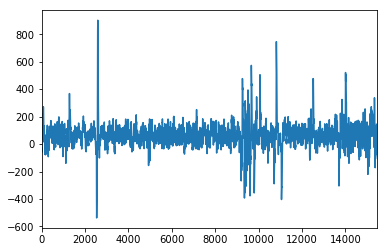

In [138]:
pd.Series(vid_vals[0]).plot()

Uneven sampling:

In [186]:
days_vid[0]['time'].value_counts()

15:52:03    531
15:51:49    525
15:52:02    523
15:52:04    519
15:52:14    518
15:52:12    517
15:52:06    516
15:51:46    516
15:52:10    516
15:52:08    516
15:51:59    515
15:52:07    515
15:51:47    515
15:52:09    515
15:52:05    515
15:51:58    514
15:52:13    514
15:52:00    514
15:51:45    513
15:51:50    513
15:51:55    512
15:51:54    512
15:51:53    512
15:51:57    512
15:51:52    512
15:51:56    512
15:51:51    512
15:52:01    508
15:52:11    505
15:51:48    498
Name: time, dtype: int64

First attempt:

In [180]:
# take in array of strings representing times
# replace each chunk of consecutive times with integers beginning with 0.0

def timeToNum(str_arr):
    num_arr = []
    curTime = str_arr[0]
    count = 0.0
    for i in str_arr:
        if i != curTime:
            count += 1.0
            curTime = i
        num_arr.append(count) 
    num_arr = np.asarray(num_arr)
    return num_arr

In [143]:
time_count_vals = {}

for i in range(len(time_vals)):
    if i == 36:
        continue
    time_count_vals[i] = timeToNum(time_vals[i])

I'm using the Lomb-Scargle method because values for each second are unevenly sampled.

In [145]:
import scipy.signal as signal
import matplotlib.pyplot as plt

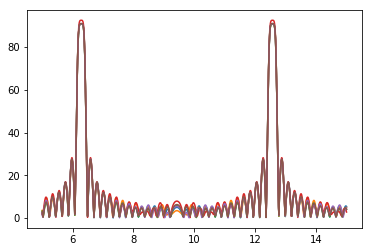

In [182]:
pgram = {}
for i in range(1,7):
    f = np.linspace(5, 15, 1000)   # output frequencies: low, high, nout
    pgram[i] = signal.lombscargle(time_count_vals[i], vid_vals[i], f)
    normval = time_count_vals[i].shape[0]
    plt.plot(f, np.sqrt(4*(pgram[i]/normval)))

In [187]:
def makeCountArr(str_arr):
    num_arr = []
    count = 0.0
    for i in str_arr:
        num_arr.append(count) 
        count += 1.0
    num_arr = np.asarray(num_arr)
    return num_arr

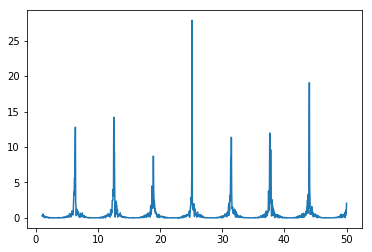

In [201]:
count_arrs = {}
pgram2 = {}

for i in range(1):
    if i == 36:
        continue
    count_arrs[i] = makeCountArr(time_vals[i])
    f2 = np.linspace(1, 50, 1000)   # output frequencies: low, high, nout
    pgram2[i] = signal.lombscargle(count_arrs[i], vid_vals[i], f2)
    normval = count_arrs[i].shape[0]
    plt.plot(f2, np.sqrt(4*(pgram2[i]/normval)))

Obviously not useful or correct information.
Take 2: partitioning into groups of 512.

In [299]:
# funcy.partition wasn't working, so wrote my own function

def split_up(flat):
    listoflists = []
    curLst = []
    count = 0
    for i in range(len(flat)):
        curLst.append(flat[i])
        if i%512 == 511:
            listoflists.append(curLst)
            curLst = []
    return listoflists

split_up(days)

In [306]:
day0lst = split_up(vid_vals[0])

In [44]:
# from Lab 1

def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

What happens with the original vid_vals[0]:

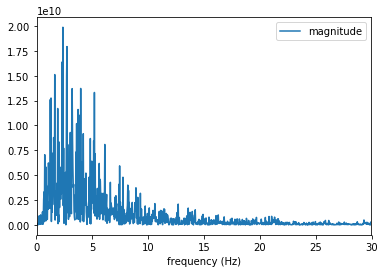

In [544]:
testOrig = to_power_spectrum(vid_vals[0])
bandpass(testOrig, 0, 30).plot(x='frequency (Hz)')

What happens with the first second (512 values) from day0lst:

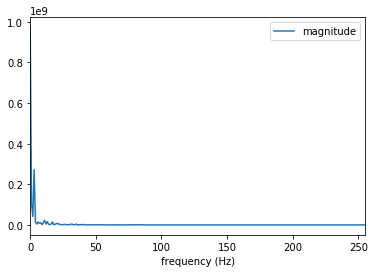

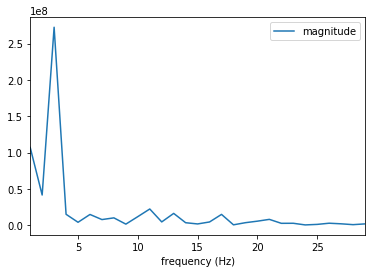

In [343]:
testSplit = to_power_spectrum(day0lst[0])
testSplit.plot(x='frequency (Hz)')
bandpass(testSplit, 0, 30).plot(x='frequency (Hz)')

In [344]:
df = bandpass(to_power_spectrum(day0lst[i]), 1, 30)
print(df.loc[df['magnitude'].idxmax()])   # get frequency for max amplitude

frequency (Hz)    2.000000e+00
magnitude         3.910608e+08
Name: 2, dtype: float64


frequency (Hz)    8.000000e+00
magnitude         3.666998e+07
Name: 8, dtype: float64
frequency (Hz)    2.000000e+00
magnitude         7.251800e+07
Name: 2, dtype: float64


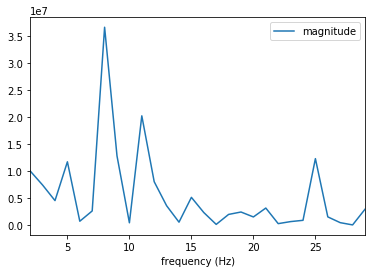

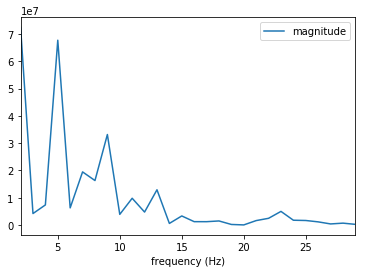

In [716]:
for i in range(7,9):
    cur = bandpass(to_power_spectrum(day0lst[i]), 1, 30)
    cur.plot(x='frequency (Hz)')
    print(cur.loc[cur['magnitude'].idxmax()])   # get frequency for max amplitude


#### After looking at the data, it seems pretty noisy. 

Instead I try the thinking task, since the power spectra look much cleaner.

Below I build arrays corresponding to the 'thinkOfItems-ver2' event. I often noticed two max peaks with similar amplitude (around 2 and 11 Hz) splitting each day's power spectra, so I bandpass from 0 to 7 and 7 to 20.

I save dictionaries with data for each day's power spectra, standard deviation, and argmax.

In [418]:
import numpy as np

In [553]:
days_think = {}
think_vals = {}
think_agg = {}
think_ps_low = {}
think_ps_high = {}
think_std_low = {}
think_std_high = {}
think_max_low = {}
think_max_high = {}

for i in range(59):
    if i == 36:
        continue
    days_think[i] = days[i][days[i].event == 'thinkOfItems-ver2']
    think_vals[i] = days_think[i].value.values
    curDay = []
    for v in think_vals[i]:
        curDay.append(v)
    think_agg[i] = np.asarray(curDay)
    think_ps_low[i] = bandpass(to_power_spectrum(think_agg[i]),0,7)    # _low: bandpass 0 to 7
    think_ps_high[i] = bandpass(to_power_spectrum(think_agg[i]),7,20)  # _high: bandpass 7 to 20
    think_std_low[i] = np.std(think_ps_low[i]['magnitude'].values)
    think_max_low[i] = (think_ps_low[i].loc[think_ps_low[i]['magnitude'].idxmax()])  # argmax for freq
    think_std_high[i] = np.std(think_ps_high[i]['magnitude'].values)
    think_max_high[i] = (think_ps_high[i].loc[think_ps_high[i]['magnitude'].idxmax()]) 

A day's power spectra.

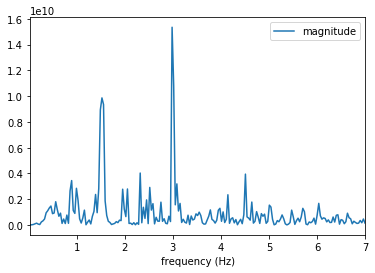

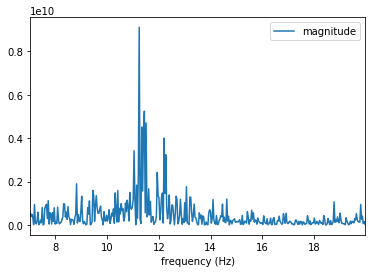

In [679]:
think_ps_low[10].plot(x='frequency (Hz)')
think_ps_high[10].plot(x='frequency (Hz)')

In [585]:
# for use: If a std value is 1e11, this calculates 11

def digitsBeforeDecimal(number):
    toStr = str(number)
    count = 0.0
    for d in toStr:
        if d != '.':
            count += 1
        else:
            return count

In [697]:
x_vals_low = []
for i in range(len(think_max_low)+1):
    x_vals_low.append(i)

all_max_low = []    # all argmax values
for t, val in think_max_low.items():
    all_max_low.append(val['frequency (Hz)'])
    if t == 35:
        all_max_low.append(0)
        
all_std_low = []
for t, val in think_std_low.items():
    all_std_low.append(val/(10**digitsBeforeDecimal(val)))
    if t == 35:
        all_std_low.append(0)    

mag_weights_low = []     # max amplitudes for each day
for i in range(len(think_ps_low)+1):
    if i == 36:
        mag_weights_low.append(0)
    else:
        max_val = think_ps_low[i]['magnitude'].max()
        mag_weights_low.append(max_val/(10**(digitsBeforeDecimal(max_val)-2)))

In [670]:
x_vals_high = []
for i in range(len(think_max_high)+1):
    x_vals_high.append(i)

all_max_high = []
for t, val in think_max_high.items():
    all_max_high.append(val['frequency (Hz)'])
    if t == 35:
        all_max_high.append(0)
        
all_std_high = []
for t, val in think_std_high.items():
    all_std_high.append(val/(10**digitsBeforeDecimal(val)))
    if t == 35:
        all_std_high.append(0)       

mag_weights_high = [] 
for i in range(len(think_ps_high)+1):
    if i == 36:
        mag_weights_high.append(0)
    else:
        max_val = think_ps_high[i]['magnitude'].max()
        mag_weights_high.append(max_val/(10**(digitsBeforeDecimal(max_val)-2)))

The magnitude of the max amplitude determines the size of the cross, given by mag_weights_low/high.

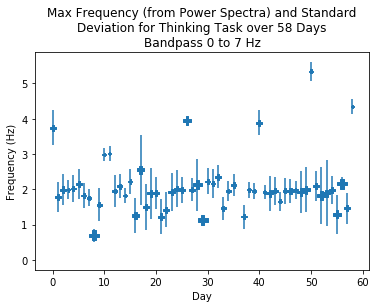

In [681]:
plt.errorbar(x_vals_low, all_max_low, all_std_low, linestyle='None')
plt.scatter(x_vals_low, all_max_low, linestyle='None', marker = 'P', s = mag_weights_low)

plt.xlabel('Day')
plt.ylabel('Frequency (Hz)')
plt.title('Max Frequency (from Power Spectra) and Standard\nDeviation for Thinking Task over 58 Days\nBandpass 0 to 7 Hz')

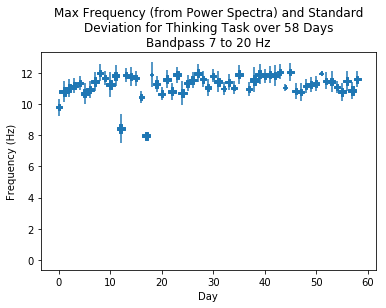

In [682]:
plt.errorbar(x_vals_high, all_max_high, all_std_high, linestyle='None')
plt.scatter(x_vals_high, all_max_high, linestyle='None', marker = 'P', s = mag_weights_high)

plt.xlabel('Day')
plt.ylabel('Frequency (Hz)')
plt.title('Max Frequency (from Power Spectra) and Standard\nDeviation for Thinking Task over 58 Days\nBandpass 7 to 20 Hz')

It's interesting that the two peaks around 2 and 11 Hz remain present throughout the full 2 months, but these plots are hard to interpret. Let's just look at the weights (magnitude in power spectra of argmax frequency; represented above by size of +) in each bandpass and see how they change.

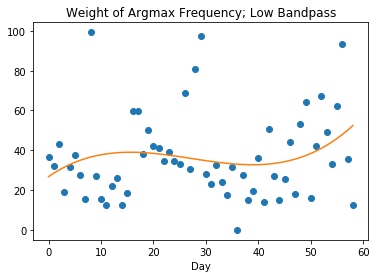

In [714]:
f = np.poly1d(np.polyfit(x_vals_low, mag_weights_low, 3))
x_fit = np.linspace(x_vals_low[0], x_vals_low[-1], 59)
y_fit = f(x_fit)
plt.plot(x_vals_low, mag_weights_low, 'o', x_fit, y_fit)
plt.xlabel('Day')
plt.title('Weight of Argmax Frequency; Low Bandpass')

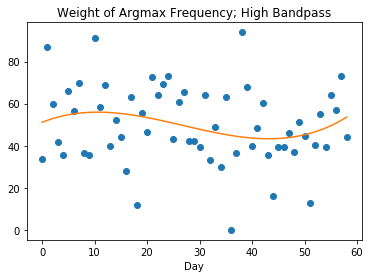

In [712]:
f = np.poly1d(np.polyfit(x_vals_high, mag_weights_high, 3))
x_fit = np.linspace(x_vals_high[0], x_vals_high[-1], 59)
y_fit = f(x_fit)
plt.plot(x_vals_high, mag_weights_high, 'o', x_fit, y_fit)
plt.xlabel('Day')
plt.title('Weight of Argmax Frequency; High Bandpass')

Visually comparing frequency amplitudes may work with a task like analyzing attention in videos, but it doesn't tell us much about how response to the thinking task changed.

In [754]:
days_relax = {}
relax_vals = {}

for i in range(59):
    if i == 36:
        continue
    days_relax[i] = days[i][days[i].event == 'relax']
    relax_vals[i] = days_relax[i].value.values

In [776]:
def to_features(vals):
    power_specs = [to_power_spectrum(v) for v in vals]
    return np.array([row.magnitude.values for row in power_specs])

def make_classifier(day):
    relax_features = to_features(split_up(relax_vals[day]))    # using split_up
    think_features = to_features(split_up(think_vals[day]))
    features = np.concatenate([relax_features, think_features])
    #assert np.all( [ len(feat) == 256 for feat in features ] )
    labels = np.array([0 for feature in relax_features] \
                    + [1 for feature in think_features])
    assert len(labels) == len(features)
    assert labels[0] == 0
    assert labels[-1] == 1
    assert features.shape[0] == labels.shape[0]
    X = features
    y = labels
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, 
        test_size=0.33, 
        random_state=42)
    clf = fresh_clf()
    clf.fit(X_train, y_train)
    sco = clf.score(X_test, y_test)
    return (clf, sco)

In [777]:
clf0, sco0 = make_classifier(0)
print(sco0)

0.85


In [783]:
def get_score(day, classif):
    relax_features = to_features(split_up(relax_vals[day]))
    think_features = to_features(split_up(think_vals[day]))
    features = np.concatenate([relax_features, think_features])
    #assert np.all( [ len(feat) == 256 for feat in features ] )
    labels = np.array([0 for feature in relax_features] \
                    + [1 for feature in think_features])
    assert len(labels) == len(features)
    assert labels[0] == 0
    assert labels[-1] == 1
    assert features.shape[0] == labels.shape[0]
    X = features
    y = labels
    score = classif.score(X, y)
    return score

In [792]:
day_x = []
day_scores = []

for i in range(1,len(relax_vals)+1): 
    if i == 36:
        continue
    score = get_score(i, clf0)
    day_scores.append(score)
    day_x.append(i)

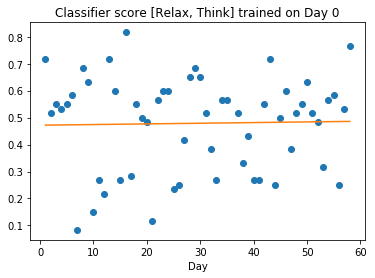

In [797]:
f = np.poly1d(np.polyfit(day_x, day_scores, 1))
x_fit = np.linspace(day_x[0], day_x[-1], 59)
y_fit = f(x_fit)
plt.plot(day_x, day_scores, 'o', x_fit, y_fit)
plt.xlabel('Day')
plt.title('Classifier score [Relax, Think] trained on Day 0')

Scores all across the board. I'd like to compare this simple way of classifying with that of the thinking task in *One-Step, Three-Factor Authentication in a Single Earpiece*.

### Ignore below
Try Subject A

In [208]:
subj_A = dataset[dataset.subject == 'A']
subj_A.label.unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x', 'breatheclosed', 'word_c',
       'phrase_c', 'face_c', 'song_c', 'sport_c'], dtype=object)

In [211]:
subj_A_0 = subj_A[subj_A.session == 0]
subj_A_1 = subj_A[subj_A.session == 1]
subj_A_2 = subj_A[subj_A.session == 2]

In [241]:
subj_A_0.label.unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face'], dtype=object)

In [242]:
subj_A_1.label.unique()

array(['unlabeled', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x'], dtype=object)

In [243]:
subj_A_2.label.unique()

array(['unlabeled', 'calibration', 'breatheclosed', 'word_x', 'word_c',
       'phrase_x', 'phrase_c', 'face_x', 'face_c', 'breatheopen', 'song_x',
       'song_c', 'sport_x', 'sport_c'], dtype=object)

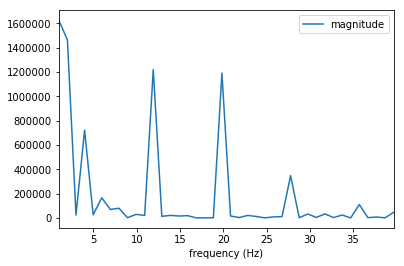

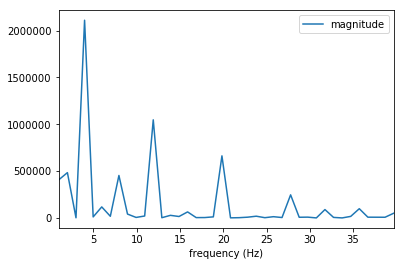

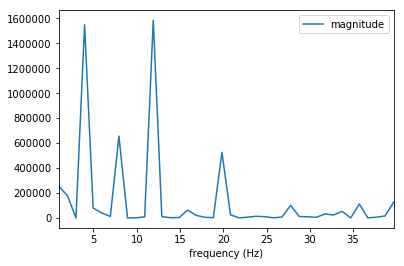

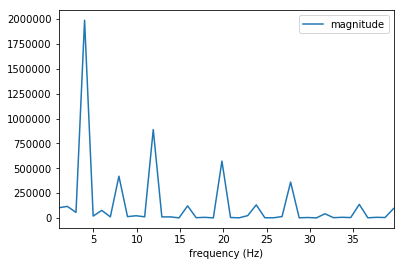

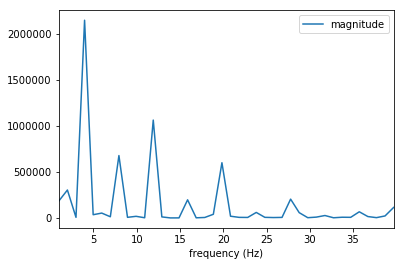

In [240]:
for i in range(0,len(subj_A_0),50):
    ps = to_power_spectrum(subj_A_0.raw_fft[i])
    bandpass(ps, 0.1, 40).plot(x='frequency (Hz)')